# Burst Clustering of Spike Trains

In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import scipy.sparse as sp
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
sns.set(style='whitegrid')

In [4]:
def loadfile(filepath, neurons):
    arr  = np.loadtxt(filepath, dtype='int', delimiter=",")
    timesteps = arr[-1, 0]
    spikes = sp.coo_matrix((arr[:,2], (arr[:,0]-1, arr[:, 1]-1)), (timesteps, neurons)).tocsc()
    return spikes

In [5]:
def getISI(spikes, neurons):
    isi = np.empty(0)
    for i in range(neurons):
        spiketrain = spikes[:, i].indices
        if(len(spiketrain) > 3):
            interval1 = np.diff(spiketrain, 1)
            interval2 = np.diff(spiketrain, 2)
            b = (2 * np.var(interval1) - np.var(interval2)) / (2 * (np.mean(interval1) ** 2))
            isi = np.append(isi, interval1)
    return isi

In [6]:
def plotHist(data, xmin, xmax, nbins):
    hist, bins = np.histogram(data, range=(xmin, xmax), bins=nbins, density=True)
    width = 0.7 * (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:]) / 2
    plt.bar(center, hist, align='center', width=width)
    plt.show()

In [7]:
def plotHistDiff(data1, data2, xmin, xmax, nbins):
    hist1, bins = np.histogram(data1, range=(xmin, xmax), bins=nbins, density=True)
    hist2, bins = np.histogram(data2, range=(xmin, xmax), bins=nbins, density=True)
    hist = hist1 - hist2
    width = 0.7 * (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:]) / 2
    plt.bar(center, hist, align='center', width=width)
    plt.show()

In [95]:
def getClusters(spikes, threshold, neurons):
    clusters = np.empty(0)
    clusters_spikes = np.empty(0)
    num_spikes = np.empty(0)
    burstLength = np.empty(0)
    bpf = np.empty(0)
    ibi = np.empty(0)
    for i in range(neurons):
        spiketrain = spikes[:, i].indices
        if(len(spiketrain) > 3):
            interval1 = np.log10(np.diff(spiketrain, 1))
            clust = np.zeros(1)
            bsize = np.zeros(1)
            bint = np.zeros(1)
            start = np.zeros(1)
            stop = np.zeros(1)
            start[0] = spiketrain[0]
            idx = 0
            for j in range(len(interval1)):
                if(interval1[j] <= threshold):
                    clust[idx] += 1
                    #bsize[idx] += interval1[j]
                elif(clust[idx] < 3):
                    clust[idx] = 0
                    #bsize[idx] = 0
                    start[idx] = spiketrain[j+1]
                else:
                    clust = np.append(clust, 0)
                    #bsize = np.append(bsize, 0)
                    stop[idx] = spiketrain[j]
                    start = np.append(start, spiketrain[j+1])
                    stop = np.append(stop, spiketrain[j+1])
                    idx += 1
            if(clust[idx] < 3):
                clust = clust[0:-1]
                #bsize = bsize[0:idx-1]
                start = start[0:-1]
                stop = stop[0:-1]
            else:
                stop[idx] = spiketrain[-1]
                
            if(len(clust) > 0 and clust[0] > 0):
                if(np.min(stop-start) < 0):
                    print(spiketrain[-10:])
                    print(clust)
                    print(stop-start)
                    print(start)
                    print(stop)
                    return
                clusters      = np.append(clusters, len(clust))
                clusters_spikes = np.append(clusters_spikes, np.mean(clust))
                num_spikes    = np.append(num_spikes, len(spiketrain))
                #burstLength    = np.append(burstLength, np.mean(bsize/clust))
                burstLength   = np.append(burstLength, np.mean(stop-start))
                bpf           = np.append(bpf, float(len(clust))/(float(len(spiketrain))/100.0))
                ibi           = np.append(ibi, start[1:]-stop[:-1])
    
    return {'num':clusters, 'size':clusters_spikes, 'nspikes':num_spikes, 'blen':burstLength, 'bpf': bpf, 'ibi': np.log10(ibi)}

In [9]:
neurons = 7520
high = loadfile("../../BrainPowerLogs/SampleLogs/Long/HighConst_Firing.csv", neurons)
med  = loadfile("../../BrainPowerLogs/SampleLogs/Long/MediumConst_Firing.csv", neurons)
low  = loadfile("../../BrainPowerLogs/SampleLogs/Long/LowConst_Firing.csv", neurons)
keto = loadfile("../../BrainPowerLogs/SampleLogs/Long/Keto_Firing.csv", neurons)
gluco  = loadfile("../../BrainPowerLogs/SampleLogs/Long/Gluco_Firing.csv", neurons)
hypo  = loadfile("../../BrainPowerLogs/SampleLogs/Long/Hypo_Firing.csv", neurons)

In [10]:
isi_high = getISI(high, neurons)
isi_med  = getISI(med, neurons)
isi_low  = getISI(low, neurons)
isi_keto = getISI(keto, neurons)
isi_gluco  = getISI(gluco, neurons)
isi_hypo  = getISI(hypo, neurons)

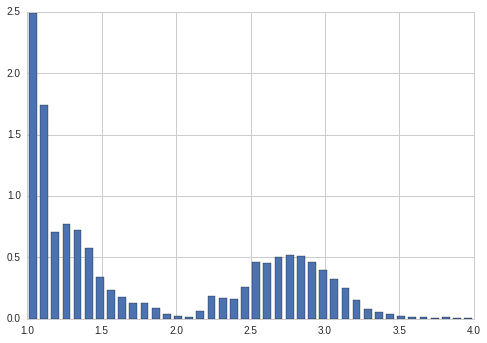

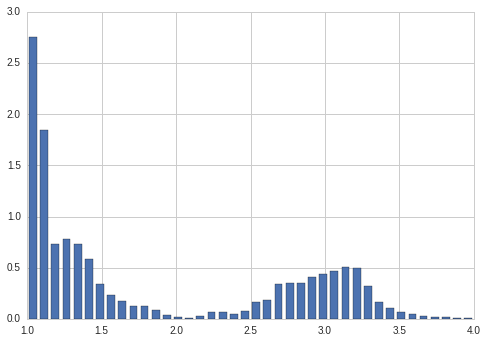

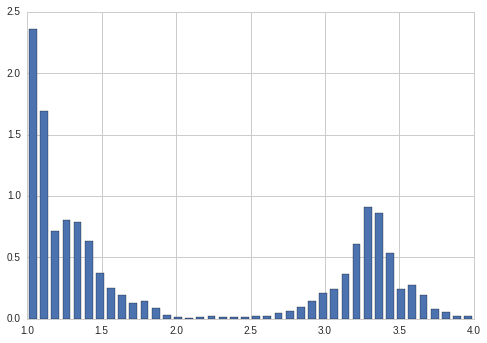

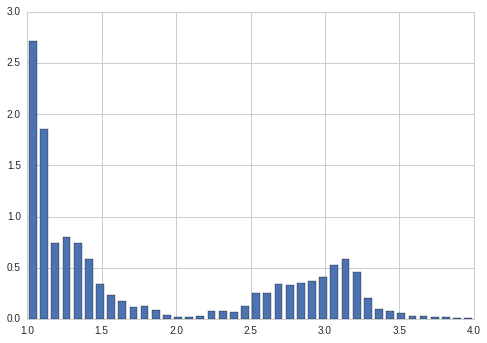

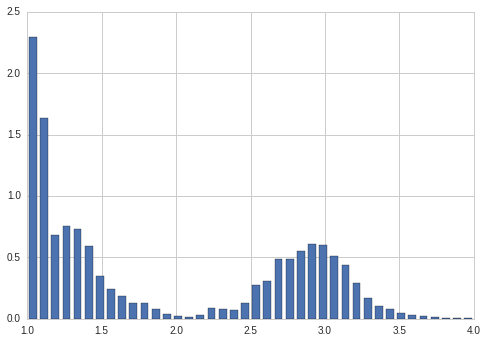

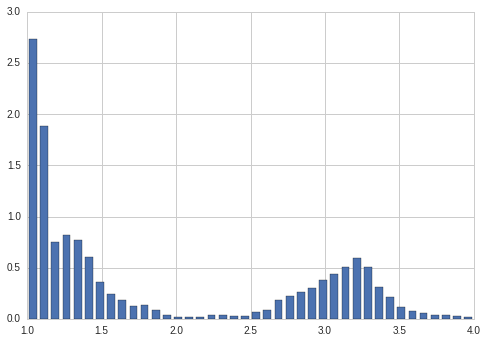

In [11]:
plotHist(np.log10(isi_high), 1, 4, 40)
plotHist(np.log10(isi_med), 1, 4, 40)
plotHist(np.log10(isi_low), 1, 4, 40)
plotHist(np.log10(isi_keto), 1, 4, 40)
plotHist(np.log10(isi_gluco), 1, 4, 40)
plotHist(np.log10(isi_hypo), 1, 4, 40)

In [96]:
threshold = 2
highClust = getClusters(high, threshold, neurons)
medClust = getClusters(med, threshold, neurons)
lowClust = getClusters(low, threshold, neurons)
ketoClust = getClusters(keto, threshold, neurons)
glucoClust = getClusters(gluco, threshold, neurons)
hypoClust = getClusters(hypo, threshold, neurons)

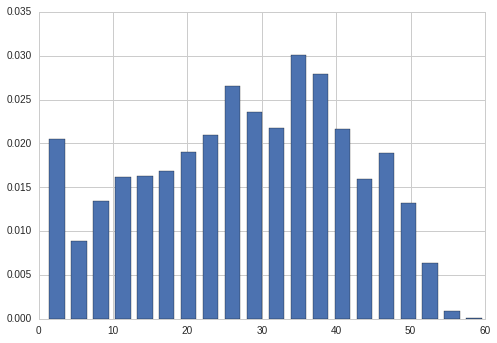

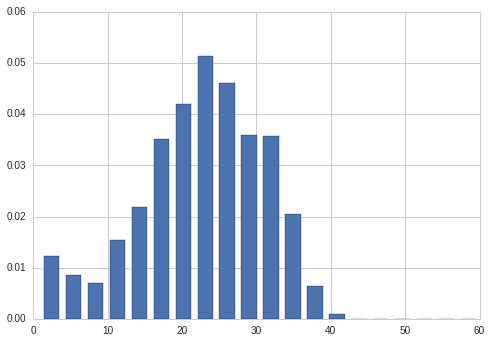

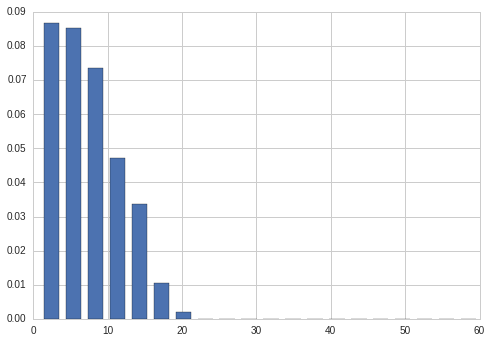

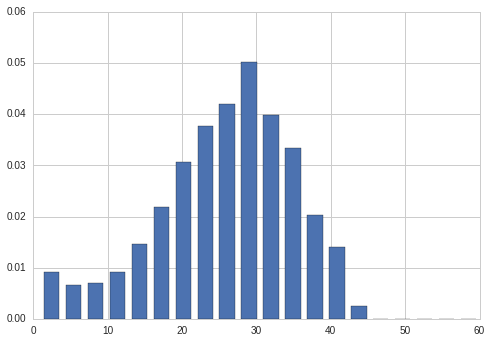

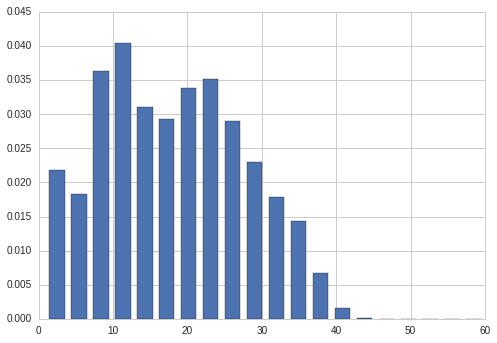

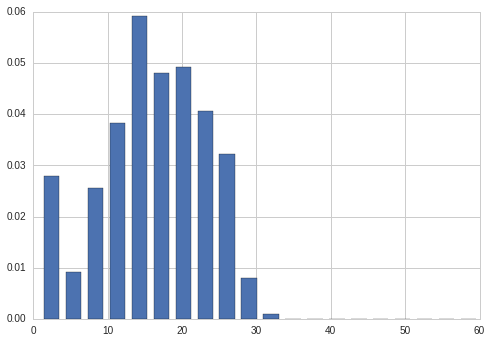

In [103]:
plotHist(highClust['num'], 1, 60, 20)
plotHist(medClust['num'],  1, 60, 20)
plotHist(lowClust['num'],  1, 60, 20)
plotHist(ketoClust['num'], 1, 60, 20)
plotHist(glucoClust['num'],  1, 60, 20)
plotHist(hypoClust['num'],  1, 60, 20)

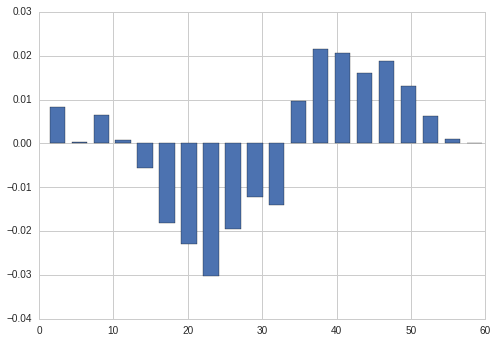

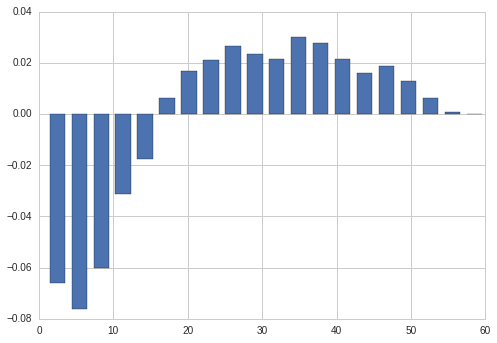

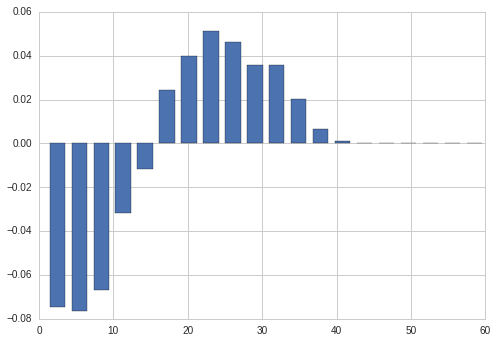

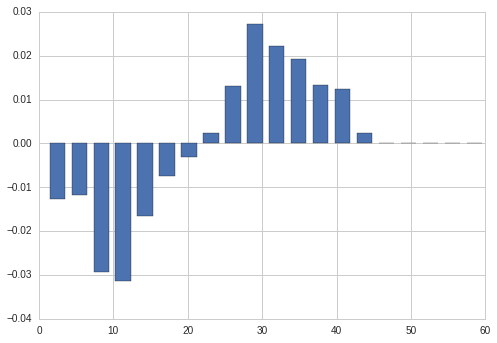

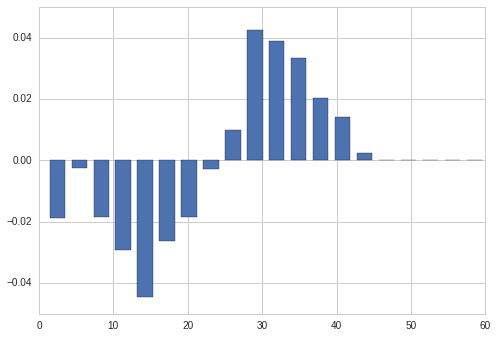

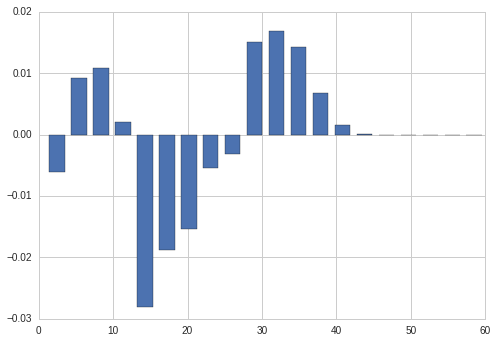

In [104]:
plotHistDiff(highClust['num'],  medClust['num'], 1, 60, 20)
plotHistDiff(highClust['num'],  lowClust['num'], 1, 60, 20)
plotHistDiff(medClust['num'],   lowClust['num'], 1, 60, 20)
plotHistDiff(ketoClust['num'],  glucoClust['num'], 1, 60, 20)
plotHistDiff(ketoClust['num'],  hypoClust['num'], 1, 60, 20)
plotHistDiff(glucoClust['num'], hypoClust['num'], 1, 60, 20)

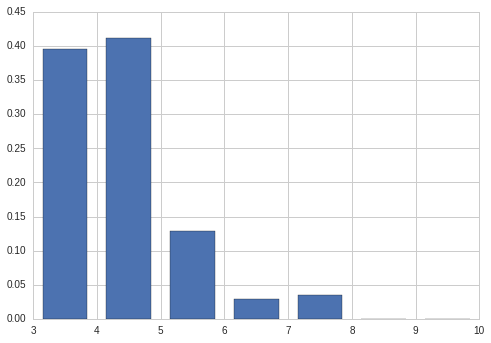

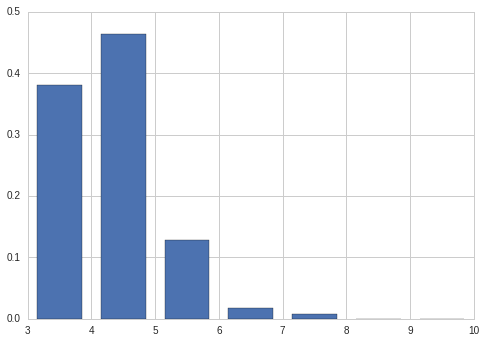

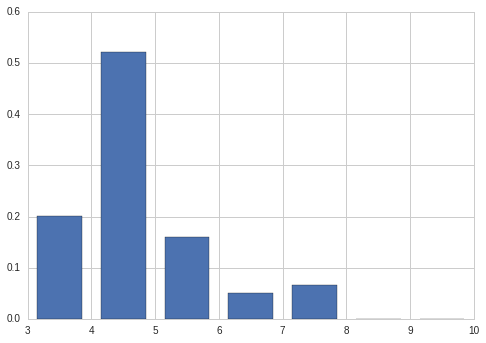

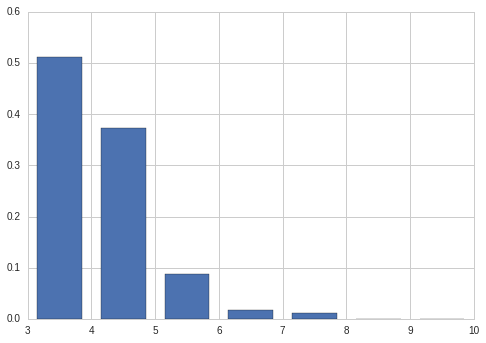

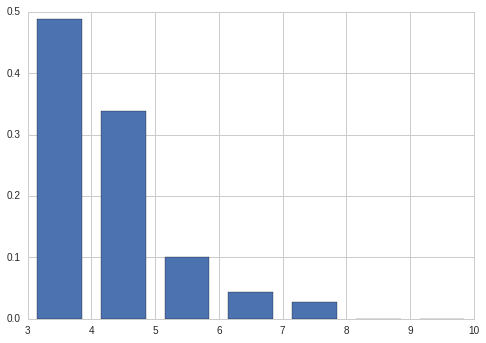

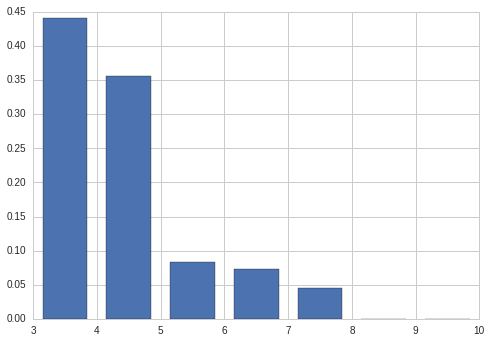

In [106]:
plotHist(highClust['size'], 3, 10, 7)
plotHist(medClust['size'], 3, 10, 7)
plotHist(lowClust['size'], 3, 10, 7)
plotHist(ketoClust['size'], 3, 10, 7)
plotHist(glucoClust['size'], 3, 10, 7)
plotHist(hypoClust['size'], 3, 10, 7)

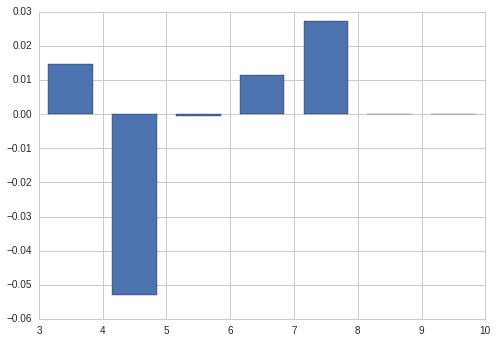

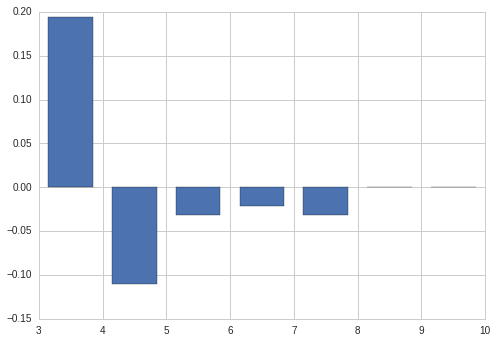

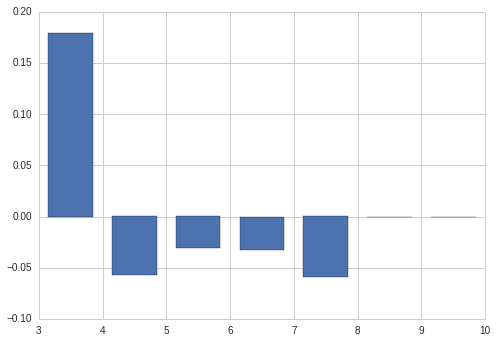

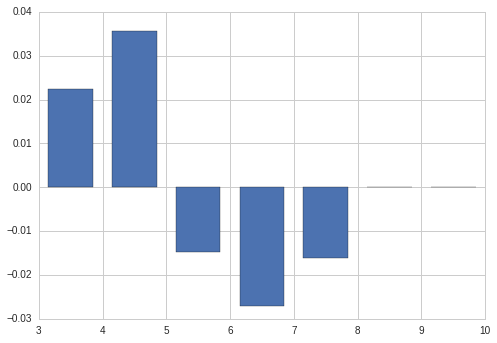

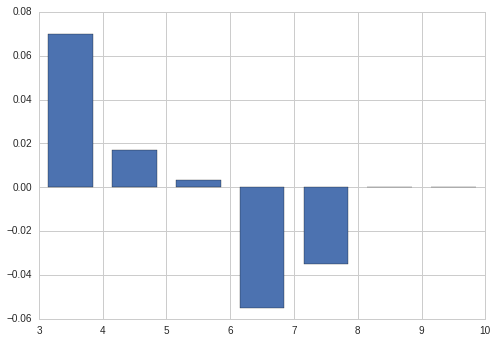

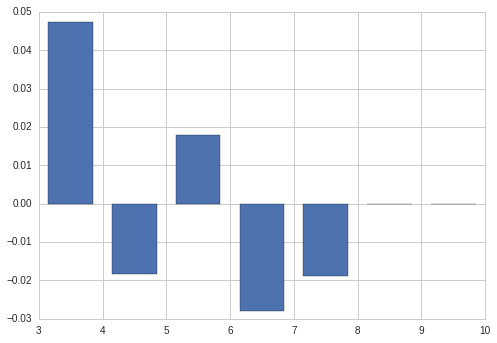

In [107]:
plotHistDiff(highClust['size'], medClust['size'], 3, 10, 7)
plotHistDiff(highClust['size'], lowClust['size'], 3, 10, 7)
plotHistDiff(medClust['size'], lowClust['size'], 3, 10, 7)
plotHistDiff(ketoClust['size'], glucoClust['size'], 3, 10, 7)
plotHistDiff(ketoClust['size'], hypoClust['size'], 3, 10, 7)
plotHistDiff(glucoClust['size'], hypoClust['size'], 3, 10, 7)

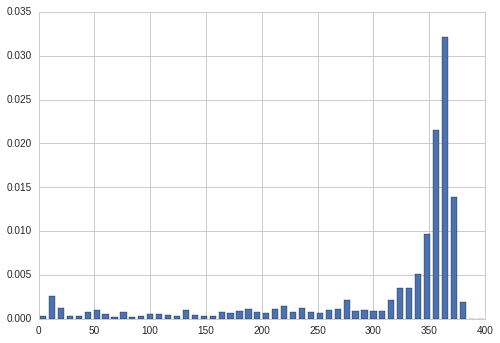

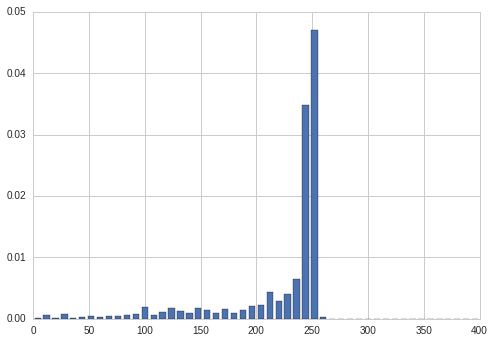

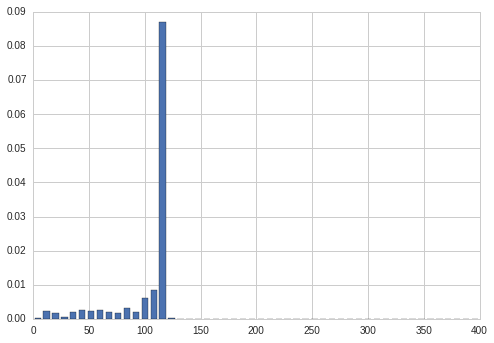

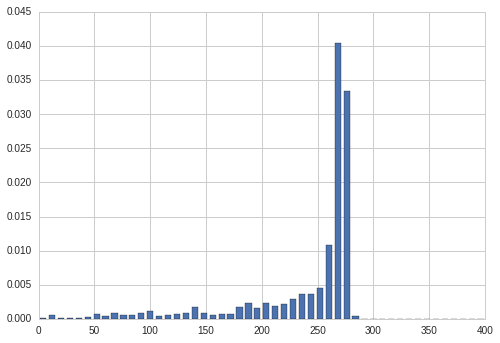

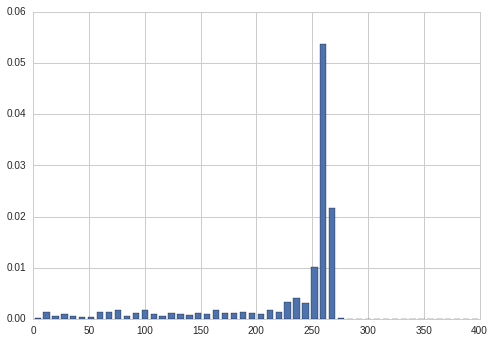

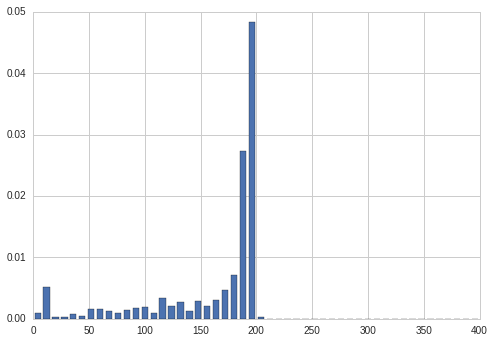

In [108]:
plotHist(highClust['nspikes'], 0, 400, 50)
plotHist(medClust['nspikes'], 0, 400, 50)
plotHist(lowClust['nspikes'], 0, 400, 50)
plotHist(ketoClust['nspikes'], 0, 400, 50)
plotHist(glucoClust['nspikes'], 0, 400, 50)
plotHist(hypoClust['nspikes'], 0, 400, 50)

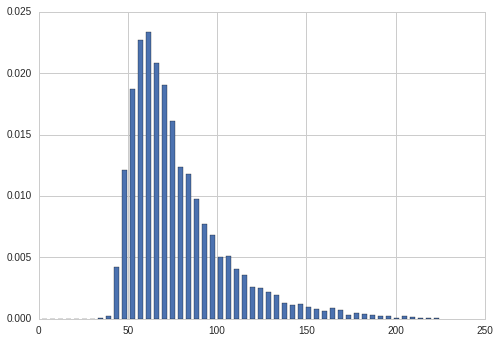

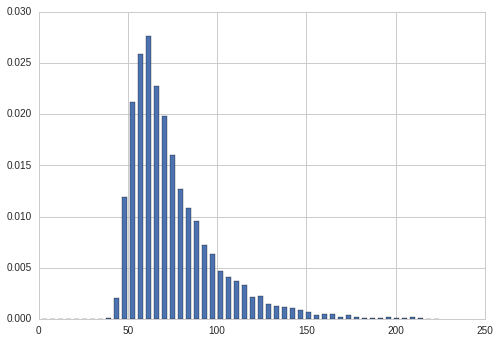

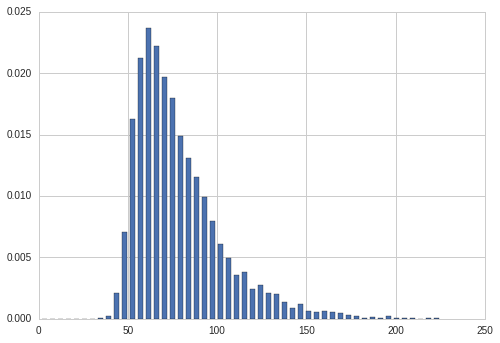

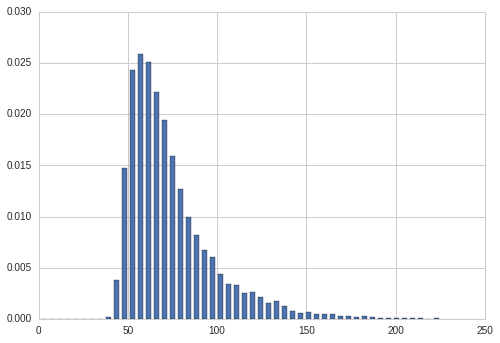

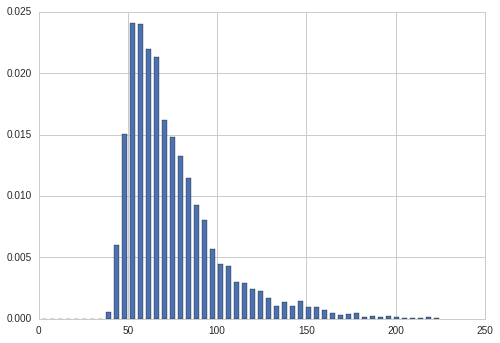

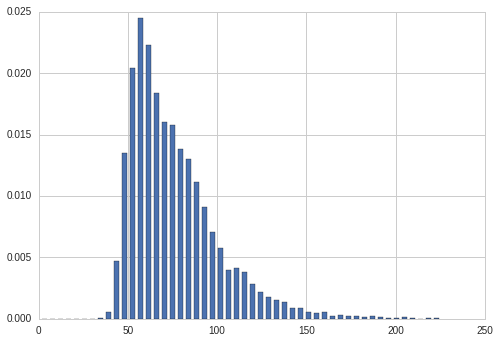

In [109]:
plotHist(highClust['blen'], 1, 225, 50)
plotHist(medClust['blen'], 1, 225, 50)
plotHist(lowClust['blen'], 1, 225, 50)
plotHist(ketoClust['blen'], 1, 225, 50)
plotHist(glucoClust['blen'], 1, 225, 50)
plotHist(hypoClust['blen'], 1, 225, 50)

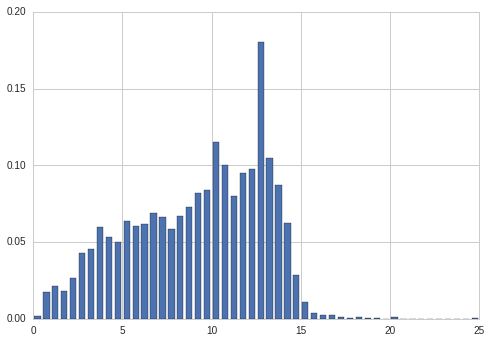

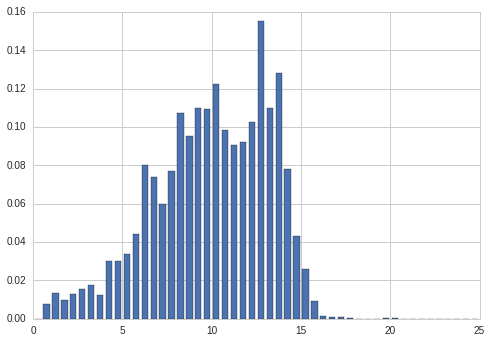

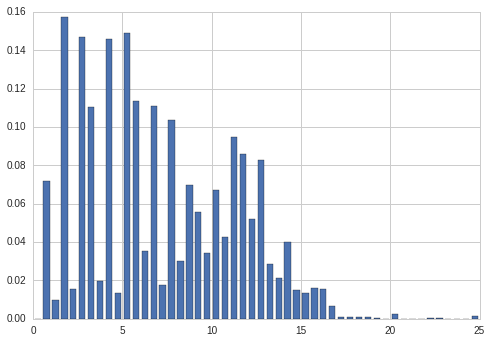

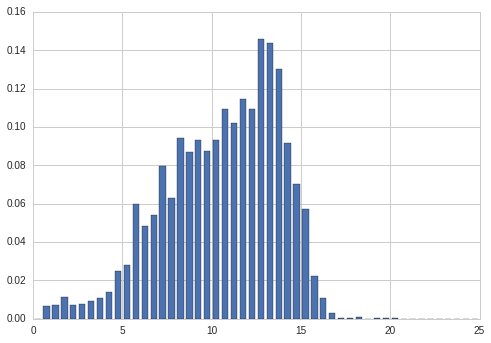

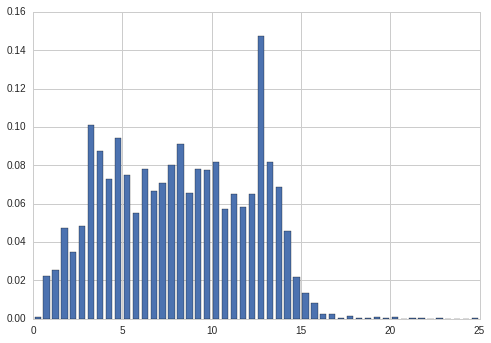

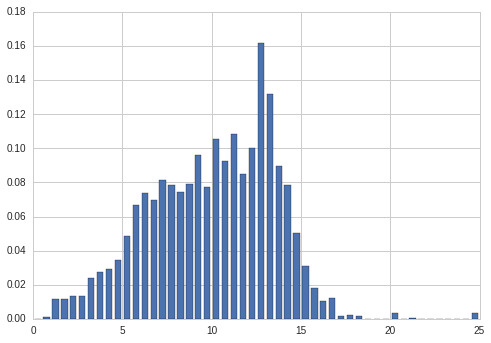

In [110]:
plotHist(highClust['bpf'], 0, 25, 50)
plotHist(medClust['bpf'], 0, 25, 50)
plotHist(lowClust['bpf'], 0, 25, 50)
plotHist(ketoClust['bpf'], 0, 25, 50)
plotHist(glucoClust['bpf'], 0, 25, 50)
plotHist(hypoClust['bpf'], 0, 25, 50)

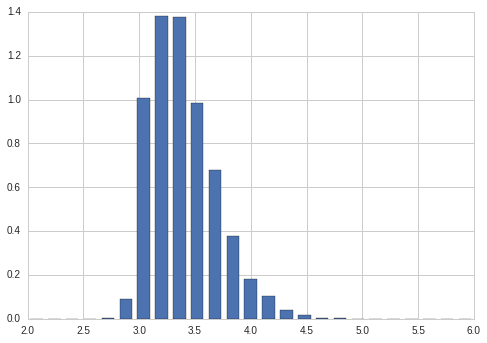

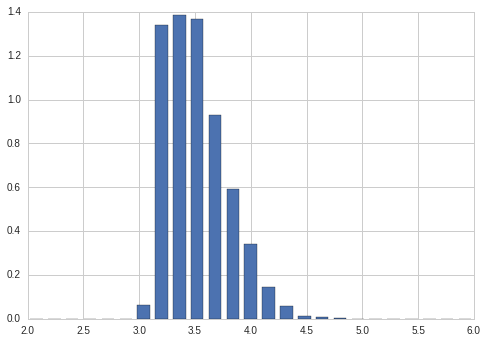

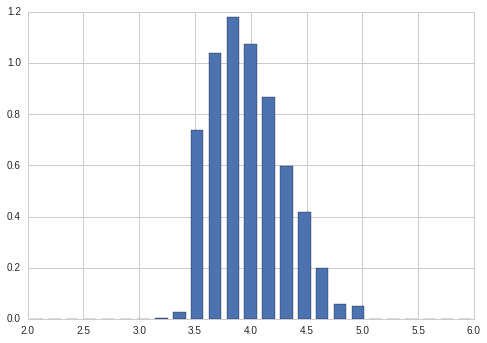

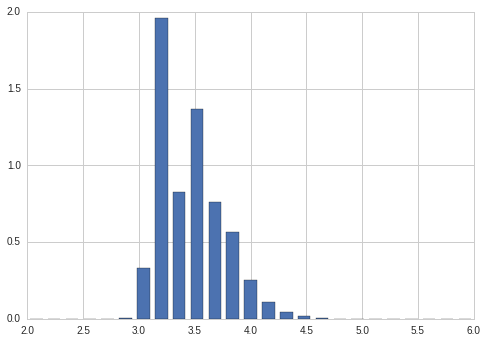

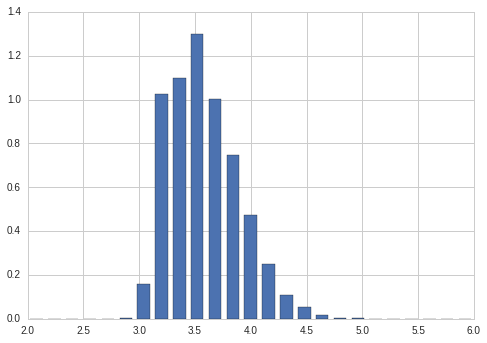

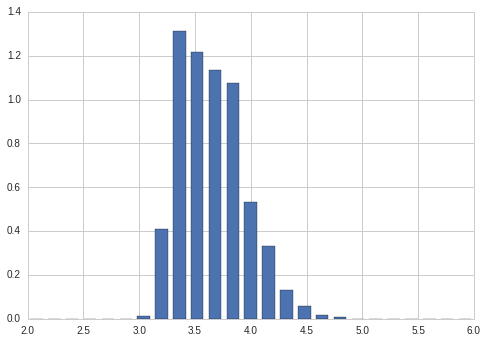

In [115]:
plotHist(highClust['ibi'], 2, 6, 25)
plotHist(medClust['ibi'], 2, 6, 25)
plotHist(lowClust['ibi'], 2, 6, 25)
plotHist(ketoClust['ibi'], 2, 6, 25)
plotHist(glucoClust['ibi'], 2, 6, 25)
plotHist(hypoClust['ibi'], 2, 6, 25)

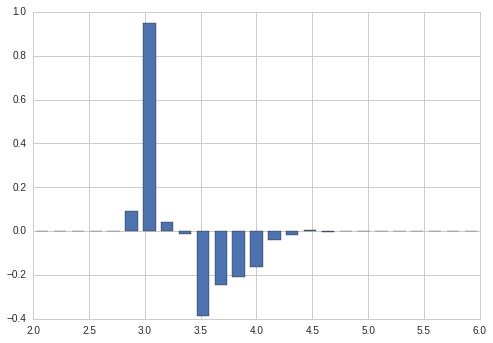

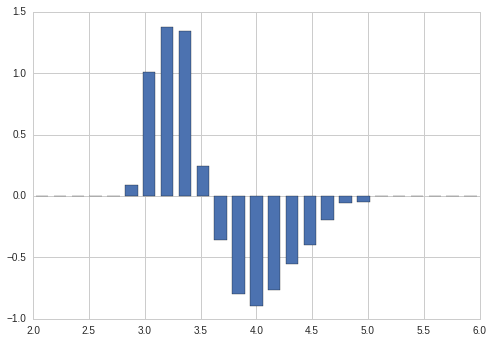

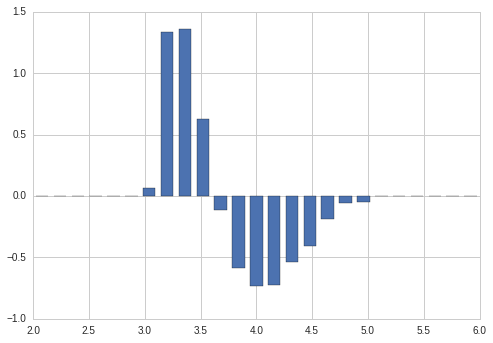

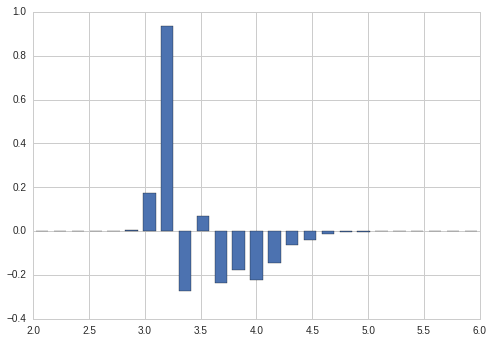

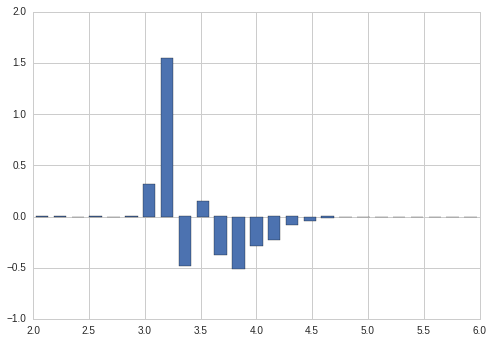

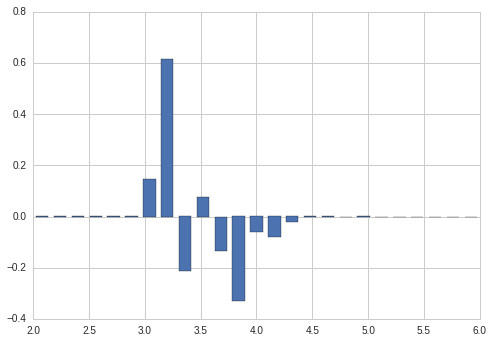

In [117]:
plotHistDiff(highClust['ibi'], medClust['ibi'], 2, 6, 25)
plotHistDiff(highClust['ibi'], lowClust['ibi'], 2, 6, 25)
plotHistDiff(medClust['ibi'], lowClust['ibi'], 2, 6, 25)
plotHistDiff(ketoClust['ibi'], glucoClust['ibi'], 2, 6, 25)
plotHistDiff(ketoClust['ibi'], hypoClust['ibi'], 2, 6, 25)
plotHistDiff(glucoClust['ibi'], hypoClust['ibi'], 2, 6, 25)